<a href="https://colab.research.google.com/github/soumikdhua/SAiDL-Summer-Assignment-2019/blob/master/Video%20Classification/Video_Classsification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **UCF-11 Video Classification with CNN ( ResNeXt )**








---

I am going to classify UCF-11 videos by extracting frame level features and feeding it into a Convolutional Neural Network. I have used a model of ResNeXt-101 pretrained on ImageNet for this video classification task. 







In [1]:
''' Importing the necessary packages'''

import numpy as np
import pandas as pd
import csv

import cv2

import torch
import torchvision
from torchvision import transforms, models
from torch import nn
import torch.nn.functional as F                                      
from torch import optim
from torch.utils.data import Dataset


from PIL import Image 

import math                                                   
import matplotlib.pyplot as plt   
%matplotlib inline

import random

import os

from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Dataset

---

I have used the UCF-11 dataset also called Youtube Action Dataset for this video classification task. 
This dataset can be downloaded from the given link : https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php


### Overview
1.   It contains 11 action categories: basketball shooting, biking/cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog.
2.   This data set is very challenging due to large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc.
3.    For each category, the videos are grouped into 25 groups with more than 4 action clips in it. The video clips in the same group share some common features, such as the same actor, similar background, similar viewpoint, and so on.
4.    "YouTube Action Data Set" is currently called "UCF11". In the updated UCF11 all the videos are converted to 29.97 fps (mpg).







In [0]:
path_to_dataset='/content/drive/My Drive/UCF11_updated_mpg'

In [3]:
'''Get the different categories of videos in this dataset and print these categories'''
categories=[]

for each_category in os.listdir(path_to_dataset):
  categories.append(each_category)

  
categories.sort()

print("There are a total of {} categories.".format(len(categories)))
print(categories)

There are a total of 11 categories.
['basketball', 'biking', 'diving', 'golf_swing', 'horse_riding', 'soccer_juggling', 'swing', 'tennis_swing', 'trampoline_jumping', 'volleyball_spiking', 'walking']


In [4]:
'''Get the names of all video files and store them in a list with their category IDs'''

videodata = []

for category_id, category_name in enumerate(categories):
  path_to_subfolder=os.path.join(path_to_dataset, category_name)

  listofvideos = list()
  
  for (dirpath, dirnames, filenames) in os.walk(path_to_subfolder):
    listofvideos += [os.path.join(dirpath, file) for file in filenames]
  
  listofvideos.sort()
  
  for each_video in listofvideos:
    videodata.append([each_video,category_id])
    
    
random.shuffle(videodata)                                                       # Shuffle the list randomly

print("There are total {} videos in this dataset.".format(len(videodata)))


There are total 1601 videos in this dataset.


In [5]:
'''I will be training on 80% of the data and keep aside 20% for testing purpose.
   Splitting the data into two training and testing sets'''

trainvideo=videodata[:(len(videodata)//10)*8]
testvideo=videodata[(len(videodata)//10)*8:]

print("There are total of {} training videos and {} testing videos.".format(len(trainvideo),len(testvideo)))

There are total of 1280 training videos and 321 testing videos.


### Analysing a single video
---







In [6]:
'''Loading a single video and getting all its features'''


for each_video , category_id in trainvideo:
  print("Processing video at ",each_video)
  cap=cv2.VideoCapture(each_video)
  fps = round(cap.get(cv2.CAP_PROP_FPS),2)
  width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  duration=round(float(total_frames)/float(fps),2)
  while(cap.isOpened()):
      frameId = cap.get(1) #current frame number
      ret, frame = cap.read()
      
      if (ret != True):
          break
  print("The video has a runtime of {} seconds with a total of {} frames and frame rate of {} fps.".format(duration,total_frames,fps))
  print("The resolution of every frame is {} x {}.".format(width,height))
  break        

Processing video at  /content/drive/My Drive/UCF11_updated_mpg/basketball/v_shooting_15/v_shooting_15_06.mpg
The video has a runtime of 5.04 seconds with a total of 151 frames and frame rate of 29.97 fps.
The resolution of every frame is 320 x 240.


In [0]:
cwd=os.getcwd()                                                                 # Get the path of present working directory

In [0]:
''' Create a folder where we will store extracted frames of our training videos'''


dir = os.path.join(cwd,"trainframes")                                           
if not os.path.exists(dir):
    os.mkdir(dir)

### Frame Extraction
---

In [9]:
'''Extract frames from the videos and store it in a separate folder from where we will load the frames for further processing.
   Also store the filename given to each frame with their category id in a list
'''


count=0
csvData = []

for each_video , category_id in trainvideo:
  print("Processing video at ",each_video)
  cap=cv2.VideoCapture(each_video)
  while(cap.isOpened()):
      frameId = cap.get(1)                                                       #current frame number
      ret, frame = cap.read()
      if (ret != True):
          break
      if (frameId % 45 == 0):                                                   #Extract every 45th frame
          filename ="/content/trainframes/trainframe%d.jpg" % count
          cv2.imwrite(filename, frame)
          csvData.append(['trainframe%d.jpg' % count,category_id])
          count+=1

random.shuffle(csvData)

csvData.insert(0,['Id', 'Category'])
print("Extraction of frames completed.")

Processing video at  /content/drive/My Drive/UCF11_updated_mpg/basketball/v_shooting_15/v_shooting_15_06.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/walking/v_walk_dog_17/v_walk_dog_17_05.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/volleyball_spiking/v_spiking_10/v_spiking_10_04.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/diving/v_diving_13/v_diving_13_04.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/diving/v_diving_04/v_diving_04_04.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/basketball/v_shooting_06/v_shooting_06_01.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/walking/v_walk_dog_25/v_walk_dog_25_03.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/basketball/v_shooting_20/v_shooting_20_05.mpg
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/trampoline_jumping/v_jumping_03/v_jumping_03_03.mpg
Processing video at  /content

In [0]:
'''Save the list as a csv file'''
with open('trainlabels.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(csvData)
writeFile.close()

In [11]:
'''Load the saved csv file and print the first few rows'''
df = pd.read_csv('/content/trainlabels.csv')
df.head(20)

,Id,Category
0,trainframe5878.jpg,8
1,trainframe4789.jpg,4
2,trainframe1428.jpg,6
3,trainframe1125.jpg,2
4,trainframe1638.jpg,0
5,trainframe2336.jpg,3
6,trainframe1227.jpg,4
7,trainframe609.jpg,6
8,trainframe1553.jpg,8
9,trainframe2347.jpg,4


### Create custom FrameDataset class and define the transforms.
  ---

In [0]:
class FrameDataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the frames.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame['Id'][idx])      # getting path of the frame
        frame = Image.open(img_name)                                            # reading the frame
        label = np.array(self.data_frame['Category'][idx])                      # reading label of the frame
        
        if self.transform:            
            frame = self.transform(frame)                                       # applying transforms, if any
        
        sample = (frame, label)        
        return sample

In [0]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
                                ])  

### Define the trainset and the trainloader and print a few samples
---

In [0]:
trainset = FrameDataset(csv_file = '/content/trainlabels.csv', root_dir = '/content/trainframes', transform=transform)     
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)

In [15]:
for i in range(len(trainset)):
    sample = trainset[i]
    print(i, sample[0].size(), " | Label: ", sample[1])
    if i == 20:
        break

0 torch.Size([3, 224, 224])  | Label:  8
1 torch.Size([3, 224, 224])  | Label:  4
2 torch.Size([3, 224, 224])  | Label:  6
3 torch.Size([3, 224, 224])  | Label:  2
4 torch.Size([3, 224, 224])  | Label:  0
5 torch.Size([3, 224, 224])  | Label:  3
6 torch.Size([3, 224, 224])  | Label:  4
7 torch.Size([3, 224, 224])  | Label:  6
8 torch.Size([3, 224, 224])  | Label:  8
9 torch.Size([3, 224, 224])  | Label:  4
10 torch.Size([3, 224, 224])  | Label:  10
11 torch.Size([3, 224, 224])  | Label:  5
12 torch.Size([3, 224, 224])  | Label:  7
13 torch.Size([3, 224, 224])  | Label:  10
14 torch.Size([3, 224, 224])  | Label:  2
15 torch.Size([3, 224, 224])  | Label:  8
16 torch.Size([3, 224, 224])  | Label:  5
17 torch.Size([3, 224, 224])  | Label:  6
18 torch.Size([3, 224, 224])  | Label:  7
19 torch.Size([3, 224, 224])  | Label:  6
20 torch.Size([3, 224, 224])  | Label:  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

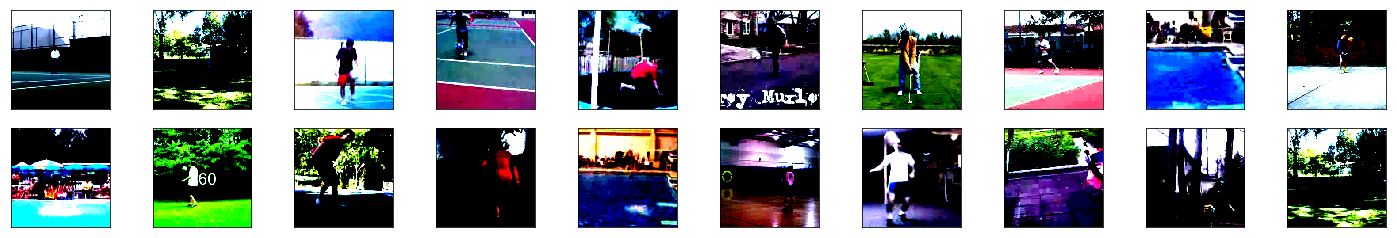

In [16]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):                                             #Change the range according to your batch-size
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0))) 

### Defining our model and Finetuning it for our classification task
---

In [17]:
model=models.resnext101_32x8d(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [0]:
for param in model.parameters():                                                # Freezing all our model parameters
    param.requires_grad = False

In [0]:
'''Finetuning the fully connected layer of our model'''

model.fc=nn.Sequential(nn.Linear(2048,150),
                       nn.LeakyReLU(),
                       nn.Linear(150,11),
                       nn.LogSoftmax(dim=1)
                         )

In [0]:
'''Move our model to GPU for training'''

if(torch.cuda.is_available()):
  model.cuda()

In [21]:
'''Get the total parameters in the model and the number of trainable parameters'''

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

87,051,347 total parameters.
309,011 training parameters.


### Defining our Criterion and Optimizer function
---

In [0]:
criterion=nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

### Training our Model
---

In [23]:
model.train()
n_epochs=5
for epoch in range(n_epochs):
  
  
  print('Epoch - {}'.format(epoch+1))
  
  
  for frames, labels in trainloader:
    running_loss=0.0
    
    if(torch.cuda.is_available()):
      frames=frames.cuda()
      labels=labels.cuda()    
    
    outputs = model(frames)  
    
    loss = criterion(outputs, labels)   
    
    loss.backward()    
    
    optimizer.step()
    
    running_loss += loss.item()
    
    print("Running loss : {}".format(running_loss))

Epoch - 1
Running loss : 2.3637807369232178
Running loss : 2.4070920944213867
Running loss : 2.365835666656494
Running loss : 2.4057745933532715
Running loss : 2.407888889312744
Running loss : 2.3551321029663086
Running loss : 2.3859760761260986
Running loss : 2.3750274181365967
Running loss : 2.3605148792266846
Running loss : 2.379265308380127
Running loss : 2.3416266441345215
Running loss : 2.332531452178955
Running loss : 2.339581251144409
Running loss : 2.362182140350342
Running loss : 2.322338342666626
Running loss : 2.3099472522735596
Running loss : 2.287526845932007
Running loss : 2.2930049896240234
Running loss : 2.288191556930542
Running loss : 2.2601099014282227
Running loss : 2.2679402828216553
Running loss : 2.292048692703247
Running loss : 2.254774808883667
Running loss : 2.2135322093963623
Running loss : 2.3181846141815186
Running loss : 2.202780246734619
Running loss : 2.2442126274108887
Running loss : 2.1990392208099365
Running loss : 2.2625162601470947
Running loss : 2

###Check performance of our model on the training set
---

In [24]:
model.eval()
correct=0
total=0
with torch.no_grad():
  for frames, labels in trainloader:
    
    if(torch.cuda.is_available()):
      frames = frames.cuda()
      labels = labels.cuda()
  
  
    outputs=model(frames)
        
    _, predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted.cpu()==labels.cpu()).sum()

  
  
accuracy=100*correct/total
print('Train Accuracy : {} %'.format(accuracy))

Train Accuracy : 90 %


###Running our model on the test set and getting Test Accuracy
---
For testing accuracy in our test set, I am loading the videos one by one. Then I am extracting frames from the video and using those frames to get all the predictions for a particular video. Then i am taking the predicted value that has repeated maximum times, i.e. the mode of the predicted values for each and every video.

In [25]:
count=0
correct=0
total=len(testvideo)

for each_video , category_id in testvideo:
  print("Processing video at ",each_video)
  csvData = [['Id', 'Category']]
  cap=cv2.VideoCapture(each_video)
  
  while(cap.isOpened()):
      frameId = cap.get(1) #current frame number
      ret, frame = cap.read()
      
      if (ret != True):
          break
      
      if (frameId % 3 == 0):
          filename ="/content/testframe%d.jpg" % count
          cv2.imwrite(filename, frame)
          csvData.append(['testframe%d.jpg' % count,category_id])
          count+=1
  
  with open('templabels.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(csvData)
  writeFile.close()
  
  testset = FrameDataset(csv_file = '/content/templabels.csv', root_dir = '/content', transform=transform)   
  testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=0)

  with torch.no_grad():
    predictions=[]
    
    for images, labels in testloader:
      if(torch.cuda.is_available()):
        images = images.cuda()
      
      output = model(images)
      
      _, pred = torch.max(output, 1)
      predicted=stats.mode(pred.cpu().numpy()).mode
      
      print('Predicted class : {}'.format(predicted))
      
      correct+=(predicted==category_id).sum()
    
      
  

Processing video at  /content/drive/My Drive/UCF11_updated_mpg/soccer_juggling/v_juggle_23/v_juggle_23_01.mpg
Predicted class : [5]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/horse_riding/v_riding_09/v_riding_09_05.mpg
Predicted class : [4]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/golf_swing/v_golf_23/v_golf_23_04.mpg
Predicted class : [10]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/soccer_juggling/v_juggle_15/v_juggle_15_01.mpg
Predicted class : [5]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/biking/v_biking_06/v_biking_06_04.mpg
Predicted class : [1]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_06.mpg
Predicted class : [1]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/tennis_swing/v_tennis_19/v_tennis_19_01.mpg
Predicted class : [7]
Processing video at  /content/drive/My Drive/UCF11_updated_mpg/trampoline_jumping/v_jumping_04/v_jumping_04_

In [26]:
testaccuracy=round(100*correct/total, 2)
print('Test Accuracy : {} %'.format(testaccuracy))

Test Accuracy : 96.26 %


###Saving my trained model
---

In [0]:
path='/content/my_ucf11_model.pth'
torch.save(model, path)